# Análise de Sobrevivência no Titanic: Um Projeto de Machine Learning

Este é um dos projetos mais icônicos para iniciantes em Ciência de Dados - a competição **Titanic: Machine Learning from Disaster** do Kaggle. O desafio consiste em analisar dados reais dos passageiros do RMS Titanic para construir um modelo preditivo que determine quais fatores contribuíram.

![Titanic](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/1200px-RMS_Titanic_3.jpg)

## Objetivo Principal

Desenvolver um **modelo de classificação** que responda à pergunta fundamental:  
**"Que tipos de passageiros tinham maior probabilidade de sobreviver ao desastre do Titanic?"**

Utilizaremos características demográficas e de viagem dos passageiros (como classe social, gênero, idade, tarifa paga, etc.) para prever o destino de cada indivíduo.

## Sobre os Dados

Trabalharemos com dois conjuntos de dados principais:

1. **train.csv**  
   - Contém informações de **891 passageiros** (amostra de treino)
   - Inclui a coluna `Survived` (0 = Não, 1 = Sim) - nosso *target*
   - Será usado para treinar e validar os modelos

2. **test.csv**  
   - Contém **418 passageiros** sem informação de sobrevivência
   - Utilizaremos para fazer previsões finais
   - Simula situações reais onde o modelo é aplicado a novos dados


### Variáveis Disponíveis:
- `Pclass`: Classe do bilhete (1ª, 2ª ou 3ª classe)
- `Name`, `Sex`, `Age`
- `SibSp`/`Parch`: Número de irmãos/cônjuges e pais/filhos a bordo
- `Ticket`, `Fare`, `Cabin`, `Embarked` (porto de embarque)

## Métrica de Sucesso
O modelo será avaliado pela **acurácia** - porcentagem de previsões corretas sobre se um passageiro sobreviveu ou não.

# 0.0 Bibliotecas e Funções

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1.0 Importando Dados

In [3]:
# O arquivo "gender_submission" serve como base para a minha submissão. Ele faz uma "previsão" básica, onde todos os homens morrem e todas as mulheres sobrevivem.
gender_submission = pd.read_csv('data/gender_submission.csv') 
training = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Rotulando dados de treino e teste para depois da concatenação
training['train_test'] = 1 # 1 para os dados que pertencem ao dataset de treino
test['train_test'] = 0 # 0 para os dados que pertencem ao dataset de teste

# Colocando uma coluna Survived no dataset de teste para padronização
test['Survived'] = np.nan

# Agora juntar os dados em full_data para que as transformações aconteçam nos dois dataframes
full_data = pd.concat([training, test])

In [4]:
# Colhendo exemplos dos dados
full_data.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
390,391,1.0,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S,1


# 2.0 Análise exploratória

## 📊 2.1 Entendendo a Natureza dos Dados
- **Métodos básicos**:
  - `.info()` - Metadados e tipos de variáveis
  - `.describe()` - Estatísticas descritivas

In [5]:
# Aqui utilizaremos alguns métodos básicos exploratórios para entender inicialmente os dados...
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [6]:
# Aqui temos noções de distribuição, com o count, media, desvio padrão e mais. 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


1. Survived: vemos que apenas **38.4%** dos passageiros sobreviveu. 

2. Classe: Média **2.31** e Mediana **3**. A maioria dos passageiros estava na 3ª classe. Isso é crucial, pois vamos ver na frente que, dependendo da classe, a taxa de sobrevivência foi maior.

3. Idade: temos uma idade média de **29.7** anos, mas temos valores faltantes (714/891 - ~20% de dados faltantes). Idade mínima = **0.42** bebês, Idade máxima = 80 anos. Será necessário
    imputar os valores faltantes (seja com média, com mediana ou etc.)

4. Família (SibSp e Parch): 
    SibSp (irmãos e conjugues): **75%** dos passageiros viajam sozinhos ou com 1 familiar - como podemos ver no quartil de 75%
    Parch (pais/filhos): 75% não tem filhos/pais a bordo - como podemos ver no quartil de 75%

5. Tarifa: Média **32.50**, mas com um alto desvio padrão -> distribuição desigual.
    Máximo = **512.33** (provável outlier, talvez passageiros ricos ou grupos)
    **75%** pagaram <= 31, enquanto a média é 32.2, ou seja, viés para tarifas menores. 
    A sugestão aqui é aplicar uma transformação logarítmica para normalizar esses valores, ou a tarifa vai influenciar muito no modelo.

6. Dados faltantes
    Age tem 177 valores faltantes (714/891)
    Cabin e Embarked também tem valores faltantes. Cabin (204/891) e Embarked (889/891)

7. Outras observações
    PassengerId: deve ser retirado, não traz informação relevante para o modelo

## 📌 Resumo das Variáveis do Dataset Titanic



### 🔠 **Variáveis Categóricas**
| Variável      | Tipo        | Descrição                          |
|---------------|-------------|------------------------------------|
| `Sex`         | Nominal     | Gênero (`male`/`female`)           |
| `Embarked`    | Nominal     | Porto de embarque (C, Q, S)        |
| `Pclass`      | Ordinal     | Classe do bilhete (1, 2, 3)        |
| `Cabin`       | Nominal     | Número da cabine                   |
| `Name` *       | Nominal     | Nome do passageiro                 | 
| `Ticket` *      | Nominal     | Número do bilhete                  |

** variáveis irrelevantes

---

### 🔢 **Variáveis Numéricas** 
| Variável      | Tipo        | Descrição                          |
|---------------|-------------|------------------------------------|
| `Age`         | Contínua    | Idade em anos                      |
| `Fare`        | Contínua    | Tarifa paga                        |
| `SibSp`       | Discreta    | Nº de irmãos/cônjuges a bordo      |
| `Parch`       | Discreta    | Nº de pais/filhos a bordo          |
| `PassengerId` | Discreta    | ID único                           |

---

### 🎯 **Variável Target**
| Variável      | Tipo        | Descrição                          |
|---------------|-------------|------------------------------------|
| `Survived`    | Binária     | 0 = Não sobreviveu, 1 = Sobreviveu |

## 🔍 Técnicas de Exploração

1. **Visualizações**:
   - Histogramas
   - Boxplots

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0, 0.5, 'Frequência')

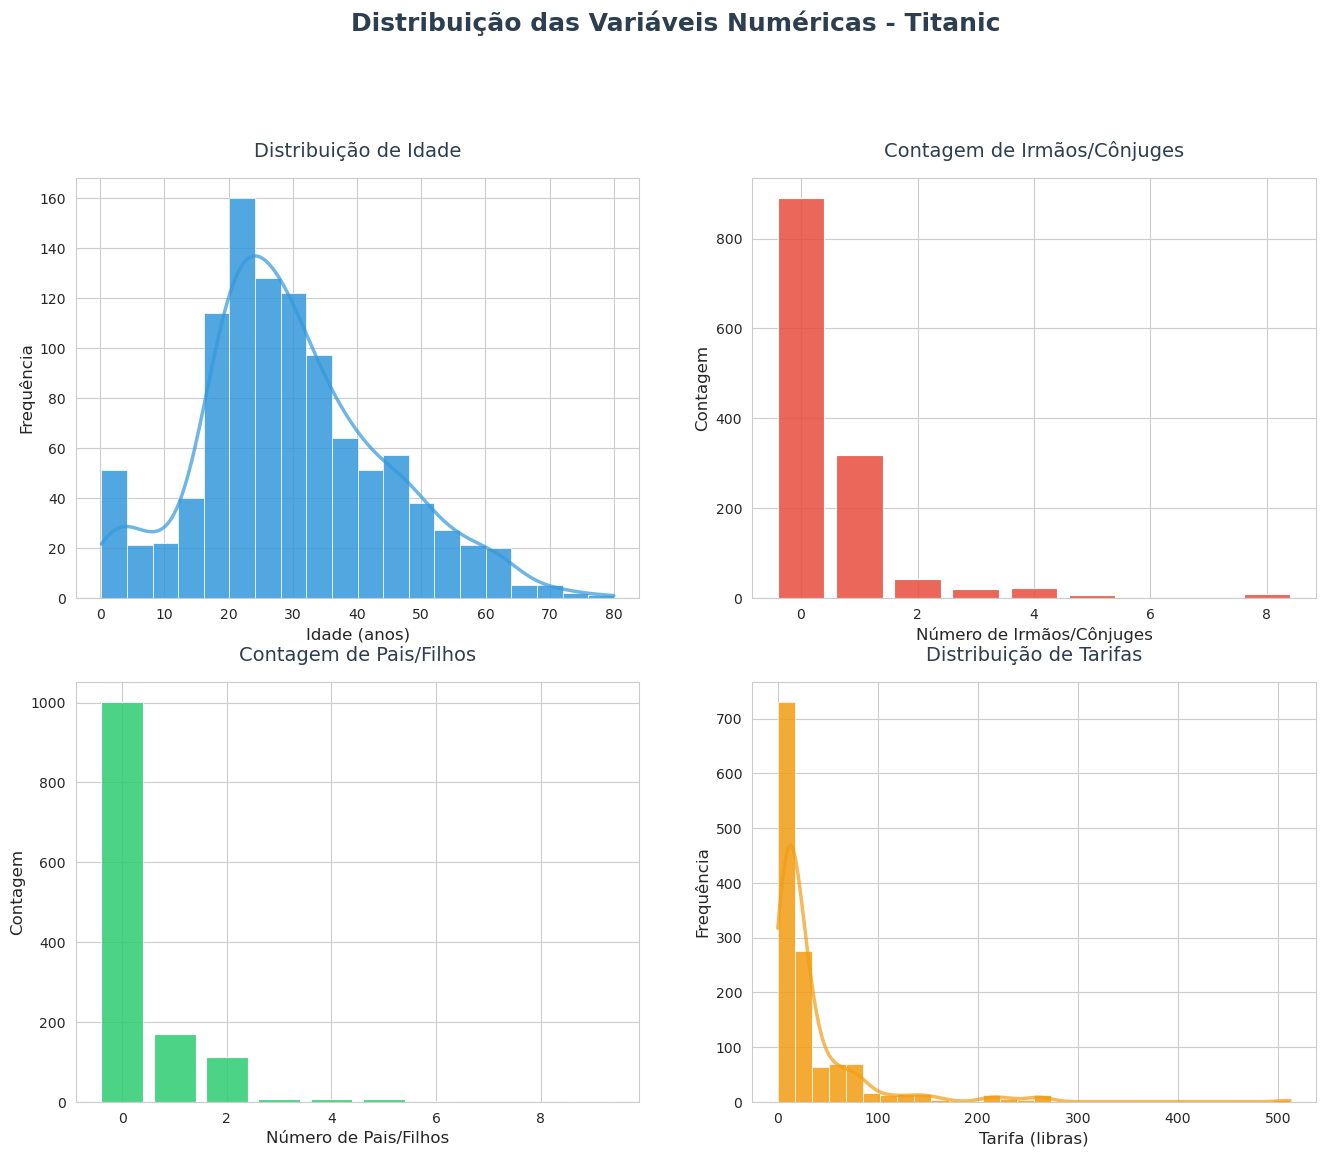

In [7]:
df_num = full_data[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = full_data[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

# fazendo uma distribuição de todas as categorias numéricas
# resetando o index
df_num = df_num.reset_index(drop=True)

# configurar o layout dos subplots
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Dejavu Sans'

# paleta de cores profissional
palette = {
    'Age': '#3498db',     # Azul vibrante
    'SibSp': '#e74c3c',   # Vermelho coral
    'Parch': '#2ecc71',   # Verde esmeralda
    'Fare': '#f39c12'     # Laranja dourado
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Distribuição das Variáveis Numéricas - Titanic', fontsize=18, y=1.02, 
             fontweight='bold', color='#2c3e50')

# --- Gráfico 1: Age ---
sns.histplot(
    data=df_num, x='Age', kde=True, ax=axes[0, 0], bins=20,
    color=palette['Age'], alpha=0.85, edgecolor='white', linewidth=0.5,
    line_kws={'color': '#2980b9', 'linewidth': 2.5, 'alpha': 0.7}  # Mudança aqui!
)
axes[0, 0].set_title('Distribuição de Idade', fontsize=14, pad=15, color='#2c3e50')
axes[0, 0].set_xlabel('Idade (anos)', fontsize=12)
axes[0, 0].set_ylabel('Frequência', fontsize=12)

# --- Gráfico 2: SibSp ---
sns.histplot(
    data=df_num, x='SibSp', discrete=True, ax=axes[0, 1], 
    color=palette['SibSp'], alpha=0.85, edgecolor='white', linewidth=0.8,
    shrink=0.8  # Controla a largura das barras discretas
)
axes[0, 1].set_title('Contagem de Irmãos/Cônjuges', fontsize=14, pad=15, color='#2c3e50')
axes[0, 1].set_xlabel('Número de Irmãos/Cônjuges', fontsize=12)
axes[0, 1].set_ylabel('Contagem', fontsize=12)

# --- Gráfico 3: Parch ---
sns.histplot(
    data=df_num, x='Parch', discrete=True, ax=axes[1, 0], 
    color=palette['Parch'], alpha=0.85, edgecolor='white', linewidth=0.8,
    shrink=0.8
)
axes[1, 0].set_title('Contagem de Pais/Filhos', fontsize=14, pad=15, color='#2c3e50')
axes[1, 0].set_xlabel('Número de Pais/Filhos', fontsize=12)
axes[1, 0].set_ylabel('Contagem', fontsize=12)

# --- Gráfico 4: Fare --- (Versão Corrigida)
sns.histplot(
    data=df_num, x='Fare', kde=True, ax=axes[1, 1], bins=30,
    color=palette['Fare'], alpha=0.85, edgecolor='white', linewidth=0.5,
    line_kws={'color': '#d35400', 'linewidth': 2.5, 'alpha': 0.7}  # Corrigido: kde_kws → line_kws
)
axes[1, 1].set_title('Distribuição de Tarifas', fontsize=14, pad=15, color='#2c3e50')
axes[1, 1].set_xlabel('Tarifa (libras)', fontsize=12)
axes[1, 1].set_ylabel('Frequência', fontsize=12)

### Reflexões

1. Distribuição de Idade (Age): A maioria dos passageiros estava entre 20 e 40 anos, com um pico nos 30 anos. Apresença de uma cauda à direita indica alguns passageiros mais idosos e também uma pequena elevação de 0-5 anos, revela a presença de crianças a bordo. Distribuição levemente assimétrica à direita.

2. Contagem de Irmão/Cônjugues (SibSp): A grande maioria dos passageiros (~75%) viajava sem irmãos ou cônjugues (valor 0). Existem poucos casos com valores acima de 2. Maior parte dos passageiros estava sozinha ou com no máximo 1 acompanhante.

3. Contagem de Pais/Filho (Parch): Padrão similar ao SibSp, com ~75% de passageiros não tendo pais ou filho a bordo. 

4. Distribuição de Tarifas (Fare): Pico próximo a £0-20, tarifa padrão da 3ª classe. Existe uma cauda longa até 500£, passageiros de primeira classe são raridade, mas parecem ter sobrevivido bem mais.

# Insights
1. Crianças e Idoso: Talvez relacionar Age com Survived possa nos mostrar se houve prioridade no resgate.

2. Tarifas altas: os poucos casos de tarifas acima de £100 merecem investigação?

3. Viajantes solitários: predominância de SibSp = 0 e Parch = 0 sugere que a maioria dos passageiros estava sozinho.


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


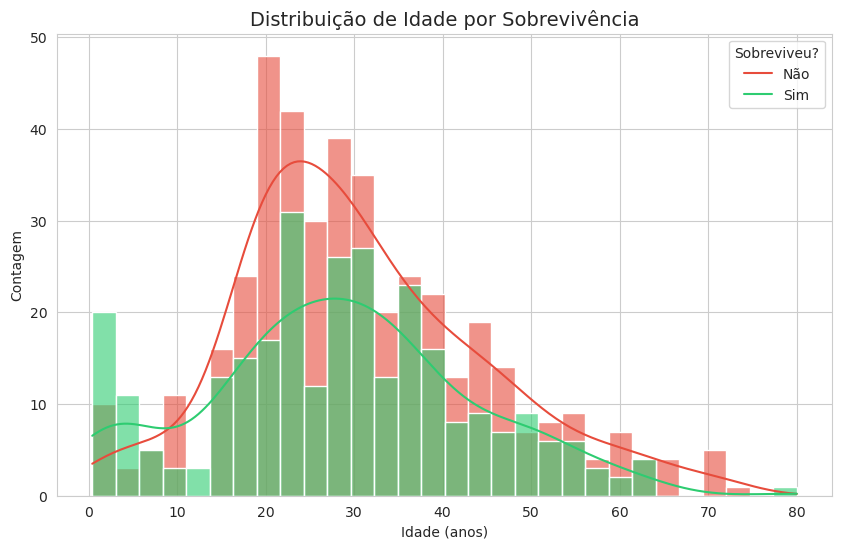

In [8]:
# Vamos relacionar Age com Survived

# Definir a ordem e cores explicitamente
plt.figure(figsize=(10, 6))
sns.histplot(
    data=training,
    x='Age',
    hue='Survived',
    bins=30,
    kde=True,
    palette={0: '#e74c3c', 1: '#2ecc71'},  # 0=Não, 1=Sim
    hue_order=[1, 0],  # Ordem explícita
    alpha=0.6
)
plt.title('Distribuição de Idade por Sobrevivência', fontsize=14)
plt.xlabel('Idade (anos)')
plt.ylabel('Contagem')
plt.legend(title='Sobreviveu?', labels=['Não', 'Sim'])  # Labels explícitos
plt.show()

In [9]:
children = training[training['Age'] <= 10]
print(children['Survived'].value_counts())

Survived
1    38
0    26
Name: count, dtype: int64


C:\Users\luimagno\AppData\Local\Temp\ipykernel_31156\160490874.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rate = training.groupby('AgeGroup')['Survived'].mean().reset_index()
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


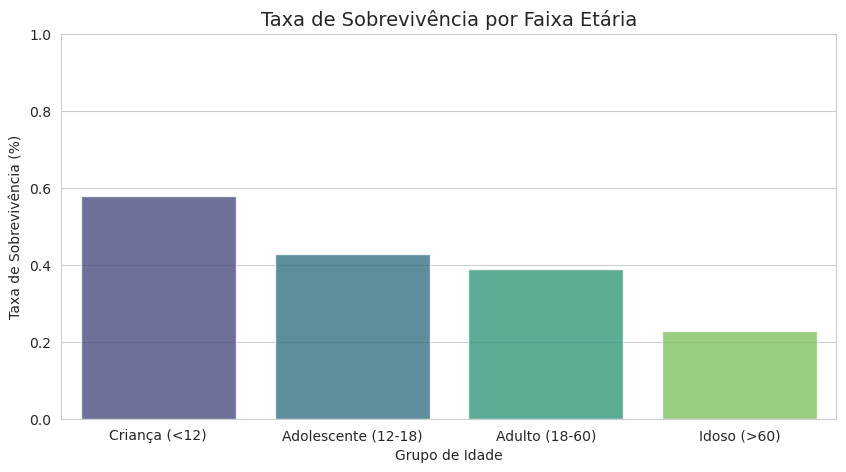

In [10]:
# Criar faixas etárias
training['AgeGroup'] = pd.cut(training['Age'], 
                             bins=[0, 12, 18, 60, 100], 
                             labels=['Criança (<12)', 'Adolescente (12-18)', 'Adulto (18-60)', 'Idoso (>60)'])

# Calcular taxa de sobrevivência por grupo
survival_rate = training.groupby('AgeGroup')['Survived'].mean().reset_index()

# Gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(
    data=survival_rate, 
    x='AgeGroup', 
    y='Survived', 
    palette='viridis', 
    alpha=0.8
)
plt.title('Taxa de Sobrevivência por Faixa Etária', fontsize=14)
plt.xlabel('Grupo de Idade')
plt.ylabel('Taxa de Sobrevivência (%)')
plt.ylim(0, 1)
plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.243699 -0.150917  0.178740
SibSp -0.243699  1.000000  0.373587  0.160238
Parch -0.150917  0.373587  1.000000  0.221539
Fare   0.178740  0.160238  0.221539  1.000000


Text(0.5, 1.0, 'Correlação entre Variáveis Numéricas')

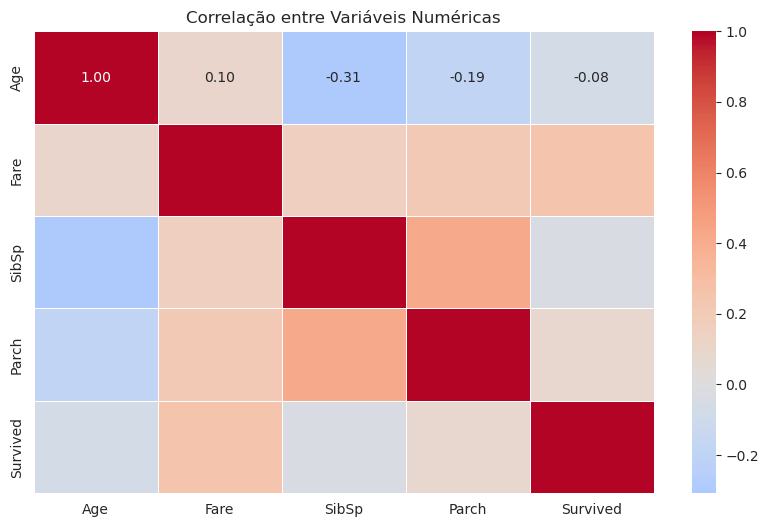

In [18]:
# fazendo um heatmap que mostre a correlação entre variáveis numéricas
print(df_num.corr())

plt.figure(figsize=(10, 6))
corr_matrix = training[['Age', 'Fare', 'SibSp', 'Parch', 'Survived']].corr()
sns.heatmap(
    corr_matrix,
    annot=True,  # Mostra valores
    fmt='.2f',   # 2 casas decimais
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Correlação entre Variáveis Numéricas')

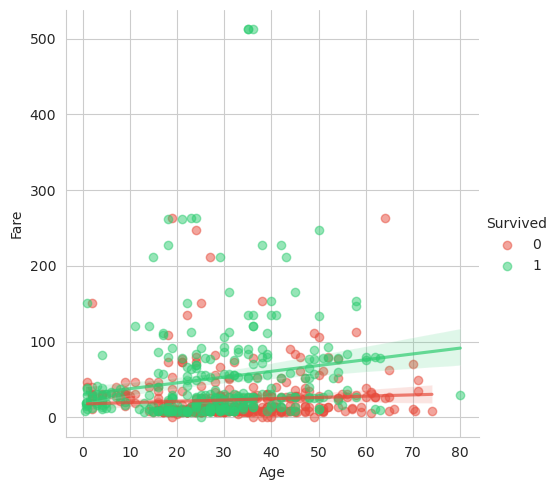

In [ ]:
sns.lmplot(
    data=training,
    x='Age',
    y='Fare',
    hue='Survived',
    palette={0: '#e74c3c', 1: '#2ecc71'},
    scatter_kws={'alpha': 0.5},
    line_kws={'alpha': 0.7}  # Mantém transparência, mas usa cor automática do hue
)

In [23]:
# comparando a taxa de sobrevivência entre: Age, SibSp, Parch e Fare
pd.pivot_table(training, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


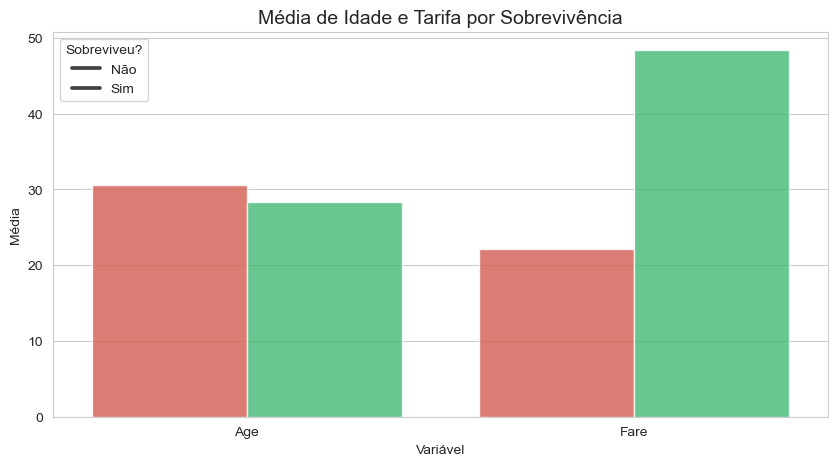

In [26]:
# Configurar estilo
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

# Transformar a pivot em formato "long" e converter Survived para string
pivot_long = pivot.reset_index().melt(id_vars='Survived', var_name='Variável', value_name='Média')
pivot_long['Survived'] = pivot_long['Survived'].astype(str)  # Conversão crucial!

# Barplot
sns.barplot(
    data=pivot_long,
    x='Variável',
    y='Média',
    hue='Survived',
    palette={'0': '#e74c3c', '1': '#2ecc71'},  # Chaves como strings!
    alpha=0.8
)

# Customização
plt.title('Média de Idade e Tarifa por Sobrevivência', fontsize=14)
plt.xlabel('Variável')
plt.ylabel('Média')
plt.legend(title='Sobreviveu?', labels=['Não', 'Sim'])
plt.show()